In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
cs = {}

In [14]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="blob2d"), 
    dict(name="diff", id="blob2d_cdiff"), 


]


for case in toload:
    casepath = db.casepaths[case["id"]]
    loadfilepath = os.path.join(casepath, "BOUT.dmp.*.nc")
    inputfilepath = os.path.join(casepath, "BOUT.inp")
    cs[case["name"]] = xbout.open_boutdataset(
        datapath = loadfilepath,
        inputfilepath = None,
        info = False,
        keep_xboundaries = False,
        keep_yboundaries = False,
        chunks = {}
    )


/ssd_scratch/scripts/xBOUT/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.01, 'Bnorm': 0.35, 'Cs0': 21884.735894...
    options:        None
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/ssd_scratch/scripts/xBOUT/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.01, 'Bnorm': 0.35, 'Cs0': 21884.735894

In [ ]:
cs["base"]

In [20]:
cs["base"].coords["dx"].values

array([[687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687.54321072],
       [687

In [21]:

for name in cs:
    ds = cs[name]
    # From the input file:
    Lrad = 0.05  # Radial width of domain [m]
    Lpol = 0.05  # Poloidal size of domain [m]

    Bpxy = 0.35  # Poloidal magnetic field [T]
    Rxy = 1.5   # Major radius [meters]
    
    nx = 260

    new_dx = ds.coords["dx"] / ds.coords["dx"] * (Lrad/(nx-4))
    new_dz = ds.coords["dz"] * (Rxy)

    print(f"The sum of new_dx is {new_dx.sum():.2e} [m].")
    print(f"The sum of new_dz is {new_dz.sum():.2e} [m].")
    
    ds = ds.assign_coords(x = np.arange(ds.sizes["x"]) * new_dx[0].values)
    ds = ds.assign_coords(z = np.arange(ds.sizes["z"]) * new_dz[0].values)

    ds.coords["x"]["unit"] = "m"
    
    cs[name] = ds

The sum of new_dx is 5.00e-02 [m].
The sum of new_dz is 5.00e-02 [m].
The sum of new_dx is 5.00e-02 [m].
The sum of new_dz is 5.00e-02 [m].


In [62]:
Omega_ci = ds.metadata["Omega_ci"]
((ds["t"] / Omega_ci).values * 1e6)[50]

74.5691768179199

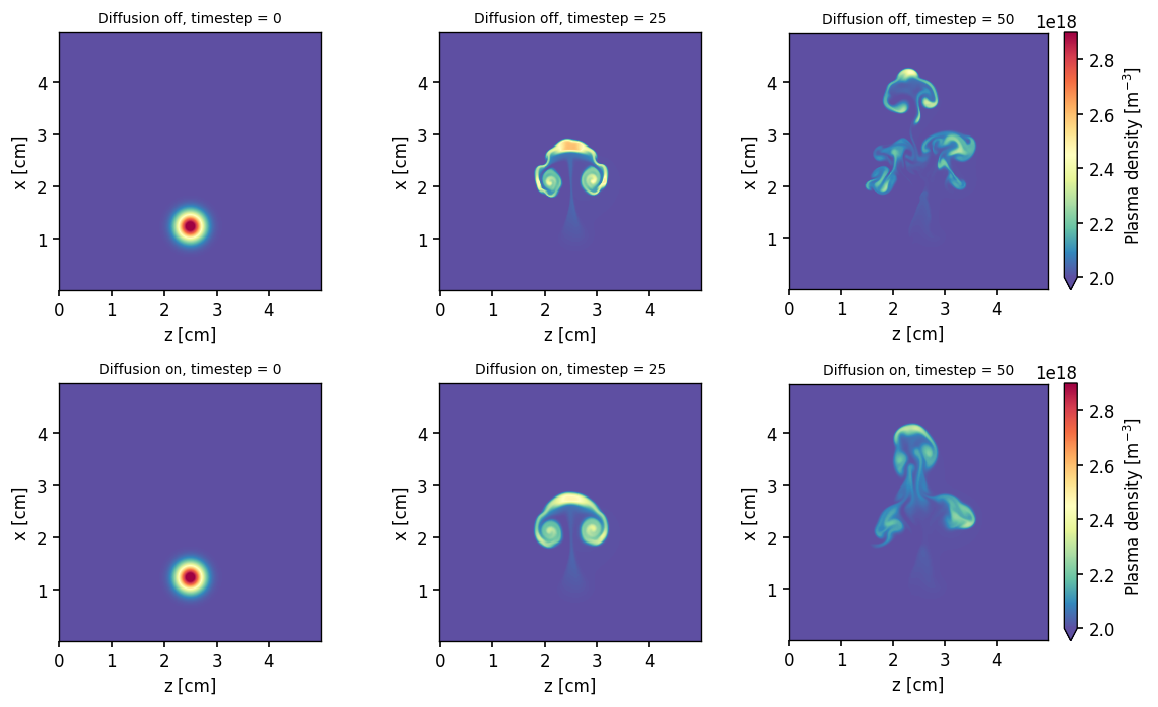

In [75]:
fig, axes = plt.subplots(2,3, figsize = (10,6))
tind = 50
vmin, vmax = 2e18, 2.9e18
ax = axes[0]

Nnorm = ds.metadata["Nnorm"]
Tnorm = ds.metadata["Tnorm"]
timesteps = [0, 25, 50]
for i, case in enumerate(cs):
    
    ds = cs[case].isel(x = slice(2,-2))
    ds = ds.assign_coords(x = ds["x"] * 100)
    ds = ds.assign_coords(z = ds["z"] * 100)
    dens = ds["Ne"] * Nnorm
    # dens = ds["Vort"]
    dens.isel(t=0).plot(ax=axes[i,0], cmap = "Spectral_r", vmin = vmin, vmax = vmax, add_colorbar = False)
    dens.isel(t=25).plot(ax=axes[i,1], cmap = "Spectral_r", vmin = vmin, vmax = vmax, add_colorbar = False)
    dens.isel(t=-1).plot(ax=axes[i,2], cmap = "Spectral_r", vmin = vmin, vmax = vmax, cbar_kwargs={"label":"Plasma density [$m^{-3}$]"})

    for j in range(3):
        axes[i,j].grid(False)
        axes[i,j].set_title(case)
        axes[i,j].set_aspect("equal")
        axes[i,j].set_xlabel("z [cm]")
        axes[i,j].set_ylabel("x [cm]")
        axes[0,j].set_title(f"Diffusion off, timestep = {timesteps[j]}", fontsize = "small")
        axes[1,j].set_title(f"Diffusion on, timestep = {timesteps[j]}", fontsize = "small")
        
fig.tight_layout()


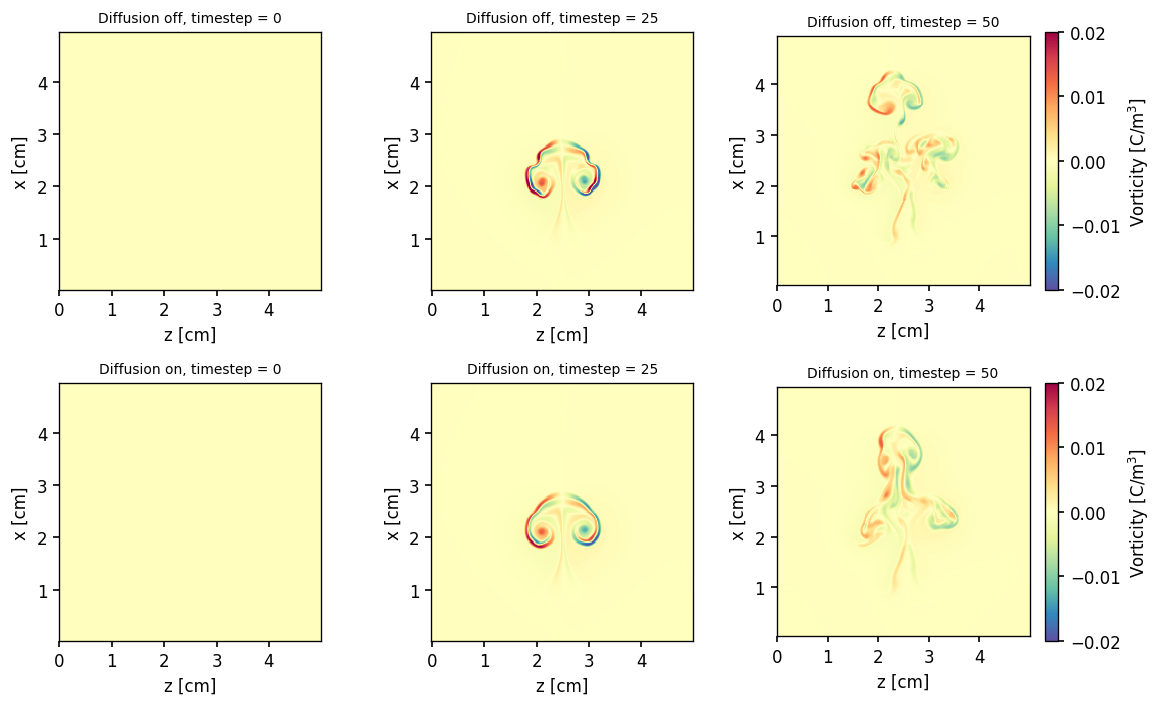

In [74]:
fig, axes = plt.subplots(2,3, figsize = (10,6))
tind = 50
vmin, vmax = -0.02, 0.02
ax = axes[0]

Nnorm = ds.metadata["Nnorm"]
Tnorm = ds.metadata["Tnorm"]
timesteps = [0, 25, 50]
for i, case in enumerate(cs):
    
    ds = cs[case].isel(x = slice(2,-2))
    ds = ds.assign_coords(x = ds["x"] * 100)
    ds = ds.assign_coords(z = ds["z"] * 100)
    # dens = ds["Ne"] * Nnorm
    dens = ds["Vort"] * Nnorm * constants("q_e")
    dens.isel(t=0).plot(ax=axes[i,0], cmap = "Spectral_r", vmin = vmin, vmax = vmax, add_colorbar = False)
    dens.isel(t=25).plot(ax=axes[i,1], cmap = "Spectral_r", vmin = vmin, vmax = vmax, add_colorbar = False)
    dens.isel(t=-1).plot(ax=axes[i,2], cmap = "Spectral_r", vmin = vmin, vmax = vmax, cbar_kwargs={"label":"Vorticity [$C/m^{3}$]"})

    for j in range(3):
        axes[i,j].grid(False)
        axes[i,j].set_title(case)
        axes[i,j].set_aspect("equal")
        axes[i,j].set_xlabel("z [cm]")
        axes[i,j].set_ylabel("x [cm]")
        axes[0,j].set_title(f"Diffusion off, timestep = {timesteps[j]}", fontsize = "small")
        axes[1,j].set_title(f"Diffusion on, timestep = {timesteps[j]}", fontsize = "small")
        
fig.tight_layout()


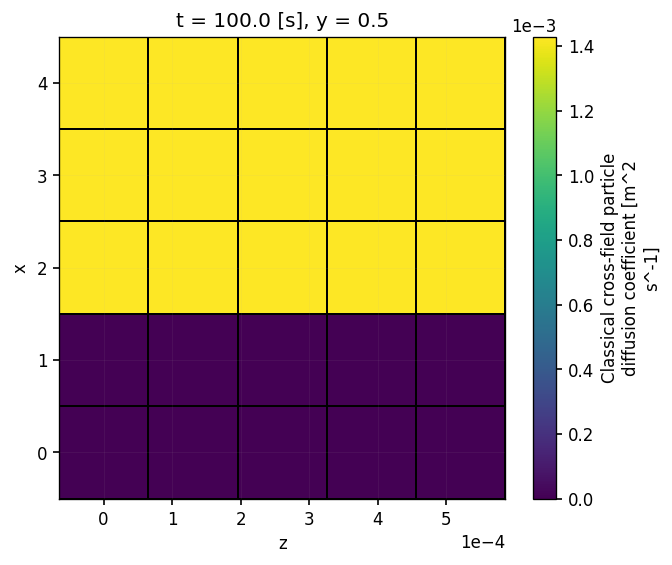

In [ ]:
fig, ax = plt.subplots()

ds = cs["diff"].isel(t=-1)
ds["D_classical"].isel(x = slice(None, 5), z = slice(None, 5)).plot(ax = ax, linewidth = 0.01, color = "k")